https://www.kaggle.com/c/sberbank-russian-housing-market/data

# **Прогнозирование продажной цены каждого объекта недвижимости**

# train and test columns

## price_doc: sale price (this is the target variable) 
## id: transaction id
## timestamp: date of transaction
## full_sq: total area in square meters, including loggias, balconies and other non-residential areas
## life_sq: living area in square meters, excluding loggias, balconies and other non-residential areas
## floor: for apartments, floor of the building
## max_floor: number of floors in the building
## material: wall material
## build_year: year built
## num_room: number of living rooms
## kitch_sq: kitchen area
## state: apartment condition
## product_type: owner-occupier purchase or investment
## sub_area: name of the district

### The dataset also includes a collection of features about each property's surrounding neighbourhood, and some features that are constant across each sub area (known as a Raion). Most of the feature names are self explanatory, with the following notes. See below for a complete list.

## full_all: subarea population
## male_f, female_f: subarea population by gender
## young_*: population younger than working age
## work_*: working-age population
## ekder_*: retirement-age population
## n_m_{all|male|female}: population between n and m years old
## build_count_*: buildings in the subarea by construction type or year
## x_count_500: the number of x within 500m of the property
## x_part_500: the share of x within 500m of the property
## _sqm_: square meters
## cafe_count_d_price_p: number of cafes within d meters of the property that have an average bill under p RUB
## trc_: shopping malls
## prom_: industrial zones
## green_: green zones
## metro_: subway
## _avto_: distances by car
## mkad_: Moscow Circle Auto Road
## ttk_: Third Transport Ring
## sadovoe_: Garden Ring
## bulvar_ring_: Boulevard Ring
## kremlin_: City center
## zd_vokzaly_: Train station
## oil_chemistry_: Dirty industry
## ts_: Power plan
## ...

# Analyse information of the table

### *predict the value of column 'price_doc'.*

# Импортирование нужных библиотек

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, metrics, preprocessing, manifold, svm
from sklearn import ensemble, neural_network, pipeline
import xgboost as xgb

In [41]:
import warnings 
warnings.filterwarnings('ignore')

In [42]:
pd.options.display.max_columns = None

In [43]:
train = pd.read_csv('train.csv')
display(train)

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

In [44]:
test = pd.read_csv('test.csv')
display(test)

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

## Analyse of the main features

In [45]:
main_features = ['timestamp', 'full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room',
                 'kitch_sq', 'product_type', 'sub_area', 'area_m', 'raion_popul', 'green_zone_part', 'indust_part', 
                 'children_preschool', 'young_all', 'work_all', 'ekder_all', 'price_doc', 'children_school', 
                 'hospital_beds_raion', 'metro_min_walk', 'market_shop_km', 'school_km', 'green_zone_km', 'mkad_km',
                 'sadovoe_km']
train_main = train[main_features]

In [46]:
train_main['timestamp'] = pd.to_datetime(train_main['timestamp'], format = '%Y-%m-%d')
train_main['year'] = train_main['timestamp'].dt.year
train_main['month'] = train_main['timestamp'].dt.month
train_main['week_of_year'] = train_main['timestamp'].dt.weekofyear

In [47]:
def day_number(row):
    year = row[28]
    week_number = row[30]
    if (year == 2011):
        return week_number
    if (year == 2012):
        return week_number + 52
    if (year == 2013):
        return week_number + 2 * 52
    if (year == 2014):
        return week_number + 3 * 52
    if (year == 2015):
        return week_number + 4 * 52
train_main['week_count'] = train_main.apply(day_number, axis = 1)

In [48]:
print(train_main.shape)
train_main.info()

(30471, 32)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            30471 non-null  datetime64[ns]
 1   full_sq              30471 non-null  int64         
 2   life_sq              24088 non-null  float64       
 3   floor                30304 non-null  float64       
 4   max_floor            20899 non-null  float64       
 5   material             20899 non-null  float64       
 6   build_year           16866 non-null  float64       
 7   num_room             20899 non-null  float64       
 8   kitch_sq             20899 non-null  float64       
 9   product_type         30471 non-null  object        
 10  sub_area             30471 non-null  object        
 11  area_m               30471 non-null  float64       
 12  raion_popul          30471 non-null  int64         
 13  green_zone_part    

In [49]:
float_features = ['full_sq', 'life_sq', 'kitch_sq', 'area_m', 'raion_popul', 'green_zone_part', 'indust_part',
                  'children_preschool', 'young_all', 'work_all', 'ekder_all', 'children_school', 'hospital_beds_raion',
                  'metro_min_walk', 'market_shop_km', 'school_km', 'green_zone_km', 'mkad_km', 'sadovoe_km']
discrete_features = ['floor', 'max_floor', 'build_year', 'num_room', 'month', 'year']
categorical_features = ['material', 'product_type', 'sub_area']

# preprocessing and research analysis

## distribution of the aim column

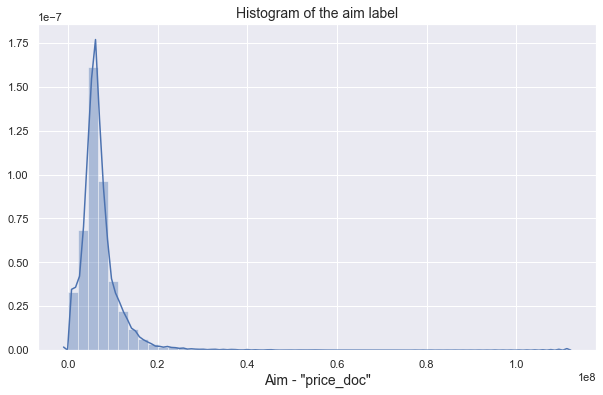

In [50]:
plt.figure(figsize = (10, 6))
sns.set(style = 'darkgrid')
sns.distplot(train_main['price_doc'])
plt.xlabel('Aim - "price_doc"', fontsize = 14)
plt.title('Histogram of the aim label', fontsize = 14)
plt.show()

### *Распределение цены на недвижимость. Видно, что основные значения лежат около 5 - 12 миллионов рублей.*

## dependence aim of week_number

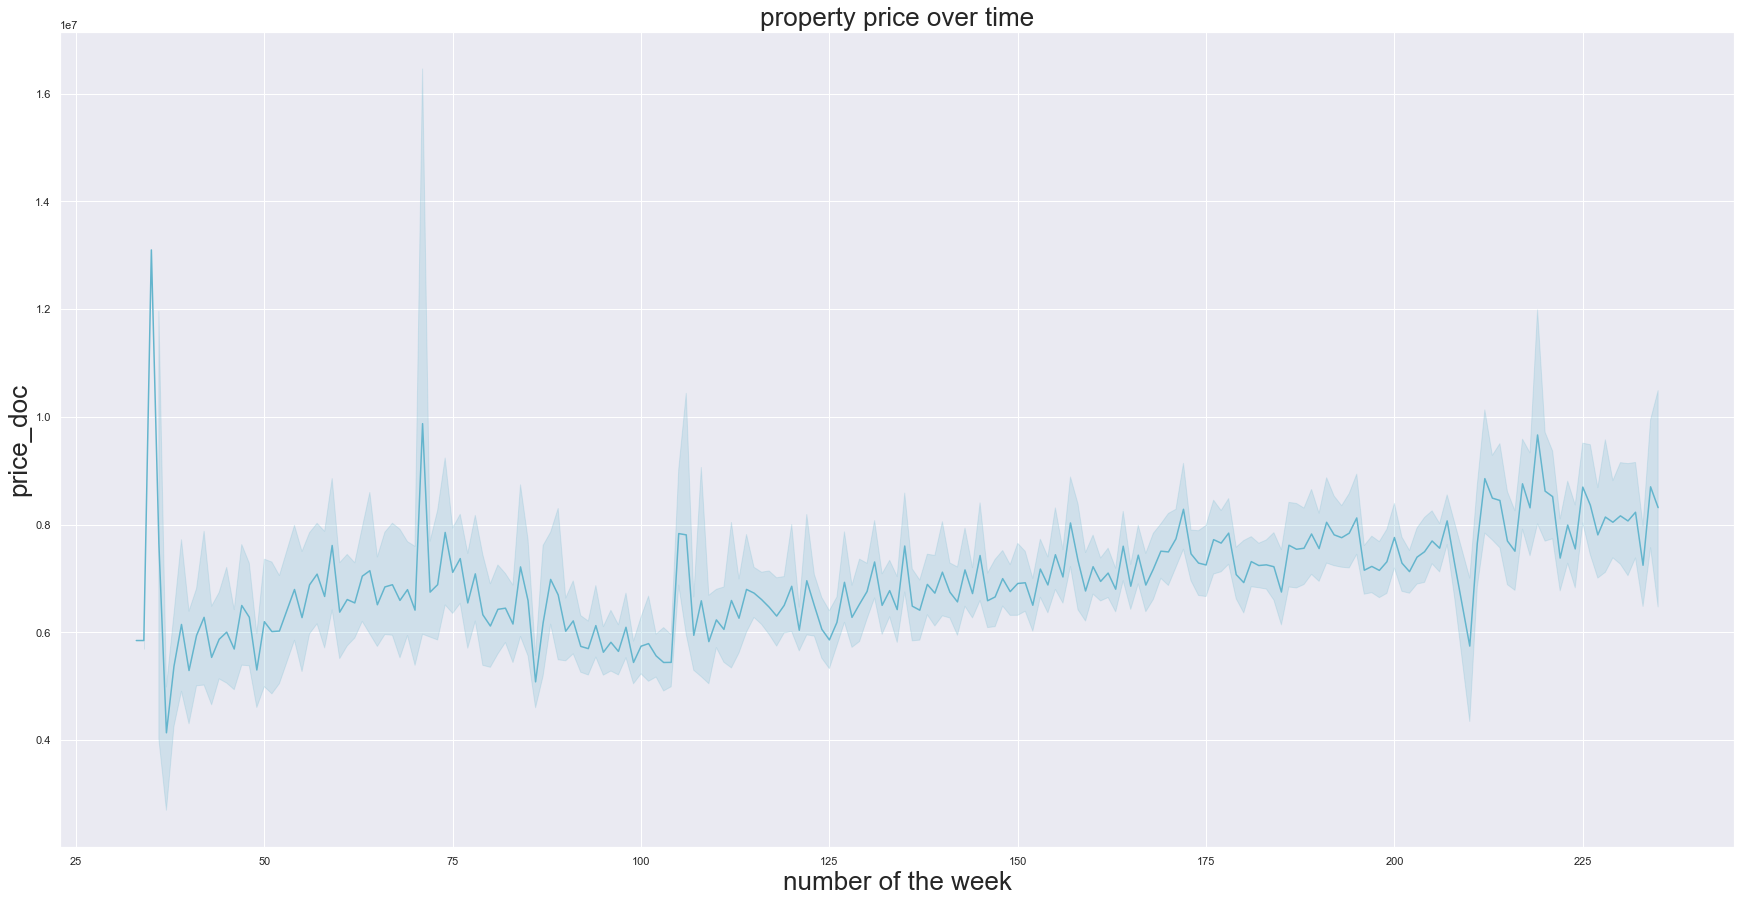

In [51]:
plt.figure(figsize = (30, 15))
sns.lineplot(x = train_main['week_count'], y = train_main['price_doc'], color = 'c')
plt.ylabel('price_doc', fontsize = 26)
plt.xlabel('number of the week', fontsize = 26)
plt.title('property price over time', fontsize = 26)
plt.show()

### *Цена на недвижимость со временем растет.*

## columns describe

In [52]:
train_main[float_features + discrete_features].describe()

,full_sq,life_sq,kitch_sq,area_m,raion_popul,green_zone_part,indust_part,children_preschool,young_all,work_all,ekder_all,children_school,hospital_beds_raion,metro_min_walk,market_shop_km,school_km,green_zone_km,mkad_km,sadovoe_km,floor,max_floor,build_year,num_room,month,year
count,30471.000000,24088.000000,20899.000000,3.047100e+04,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,16030.000000,30446.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30304.000000,20899.000000,1.686600e+04,20899.000000,30471.000000,30471.000000
mean,54.214269,34.403271,6.399301,1.765705e+07,84056.425552,0.218922,0.118871,5140.026156,11178.809491,53667.908897,19209.707164,5354.269699,1190.738677,42.737601,3.958882,1.323956,0.300511,6.274764,14.056721,7.670803,12.558974,3.068057e+03,1.909804,6.749237,2013.452726
std,38.031487,52.285733,28.265979,2.064961e+07,57871.285899,0.175090,0.118688,3816.625140,8287.957623,37483.559701,13174.721197,3989.640917,1057.015001,69.303131,3.447536,3.058145,0.298402,5.142492,8.343162,5.319989,6.756550,1.543878e+05,0.851805,3.518748,0.962433
min,0.000000,0.000000,0.000000,2.081628e+06,2546.000000,0.001879,0.000000,175.000000,365.000000,1633.000000,548.000000,168.000000,0.000000,0.000000,0.003847,0.000000,0.000000,0.013626,0.000355,0.000000,0.000000,0.000000e+00,0.000000,1.000000,2011.000000
25%,38.000000,20.000000,1.000000,7.307411e+06,21819.000000,0.063755,0.019509,1706.000000,3459.000000,13996.000000,4695.000000,1564.000000,520.000000,11.484150,1.543631,0.269716,0.100951,2.633404,8.346336,3.000000,9.000000,1.967000e+03,1.000000,4.000000,2013.000000
50%,49.000000,30.000000,6.000000,1.050803e+07,83502.000000,0.167526,0.072158,4857.000000,10988.000000,52030.000000,20036.000000,5261.000000,990.000000,20.447209,2.927417,0.474862,0.214336,5.467510,12.748712,6.500000,12.000000,1.979000e+03,2.000000,6.000000,2014.000000
75%,63.000000,43.000000,9.000000,1.803644e+07,122862.000000,0.336177,0.195781,7103.000000,14906.000000,77612.000000,29172.000000,7227.000000,1786.000000,45.322032,5.485423,0.886531,0.415498,8.184752,18.716620,11.000000,17.000000,2.005000e+03,2.000000,10.000000,2014.000000
max,5326.000000,7478.000000,2014.000000,2.060718e+08,247469.000000,0.852923,0.521867,19223.000000,40692.000000,161290.000000,57086.000000,19083.000000,4849.000000,711.215806,41.103651,47.394706,1.982448,53.277832,68.853047,77.000000,117.000000,2.005201e+07,19.000000,12.000000,2015.000000


## float columns boxplot

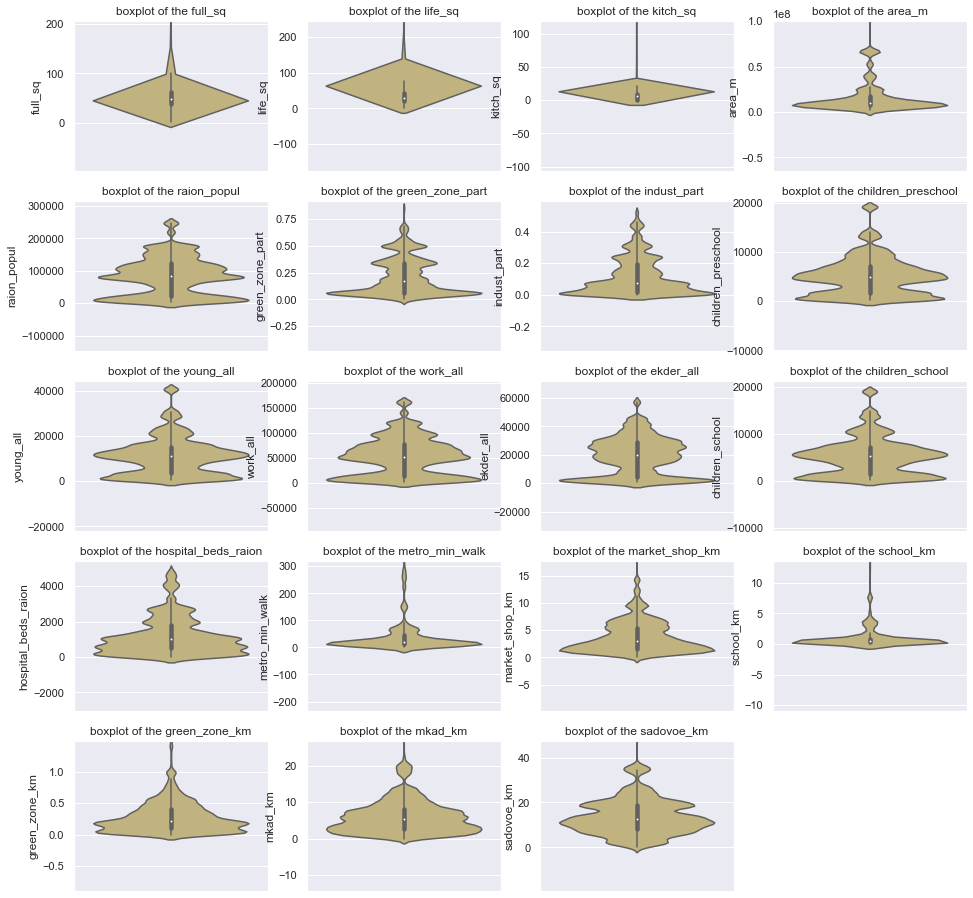

In [53]:
plt.figure(figsize = (16, 16))
subplot = 0
for feature in float_features:
    subplot += 1
    plt.subplot(5, 4, subplot)
    sns.violinplot(y = feature, data = train_main, color = 'y')
    plt.ylabel(feature)
    plt.title('boxplot of the ' + feature)
    plt.ylim(np.mean(train_main[feature]) - 4 * np.std(train_main[feature]),
             np.mean(train_main[feature]) + 4 * np.std(train_main[feature]))

### *В основном столбцы из нормального распределения и выбросов на большинстве диаграмм нету. Однако признаки area_m, children_preschool, young_all, work_all, ekder_all, children_school, metro_min_walk, school_km имеют выбросы, несложно их объяснить жизненными обстоятельствами.*

## discrete columns histogram

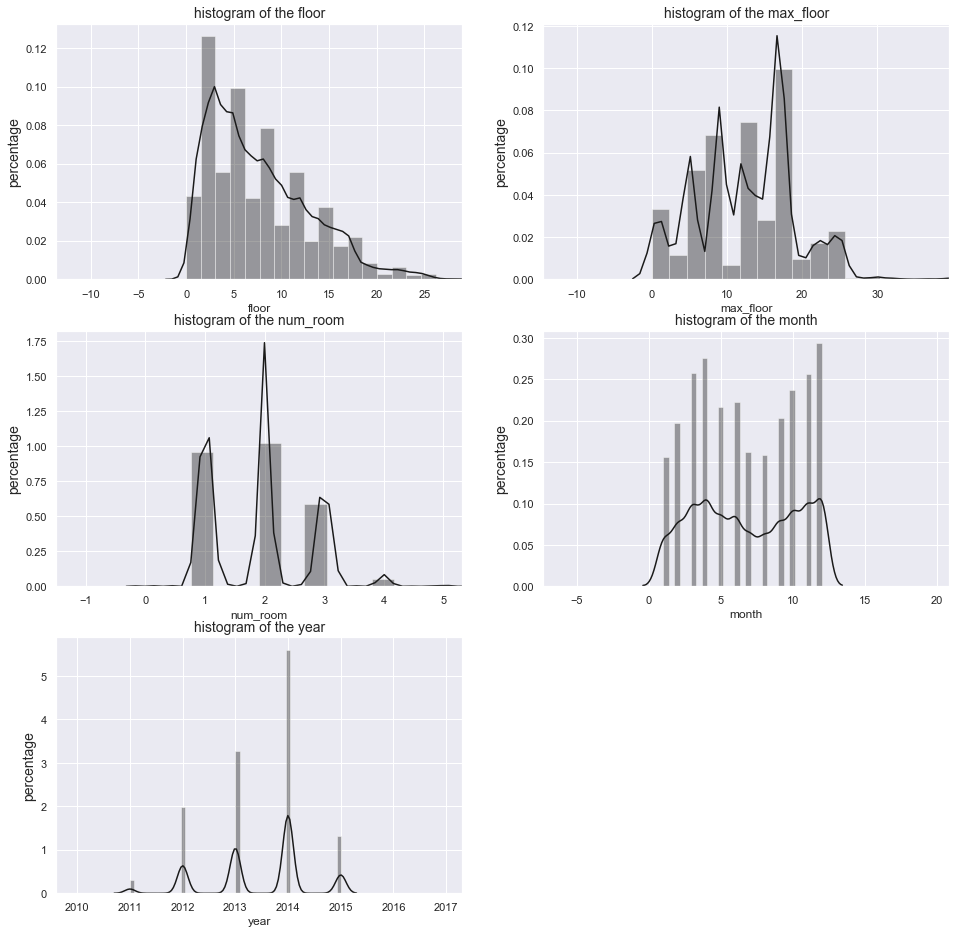

In [54]:
plt.figure(figsize = (16, 16))
subplot = 0
for feature in (discrete_features):
    if (feature != 'build_year'):
        subplot += 1
        plt.subplot(3, 2, subplot)
        sns.set(style = 'darkgrid')
        sns.distplot(train_main[feature], color = 'k')
        plt.xlim(np.mean(train_main[feature]) - 4 * np.std(train_main[feature]),
                 np.mean(train_main[feature]) + 4 * np.std(train_main[feature]))
        plt.title('histogram of the ' + feature, fontsize = 14)
        plt.ylabel('percentage', fontsize = 14)
plt.show()

### *Чаще всего встречаются квартиры на этажах от 0 до 5, с количеством комнат в 1 - 2 и больше всего данных за 2014 год.*

## correalation between aim and float features

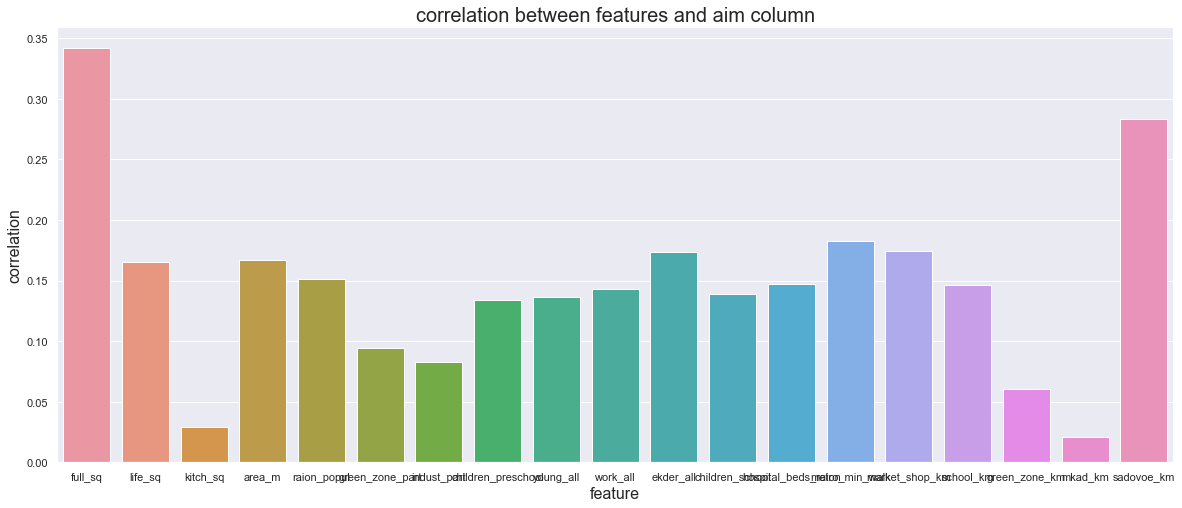

In [55]:
corr_list = [
    [],
    []
]
plt.figure(figsize = (20, 8))
for feature in float_features:
    corr = abs(train_main[feature].corr(train_main['price_doc']))
    corr_list[0].append(corr)
    corr_list[1].append(feature)
sns.barplot(x = corr_list[1], y = corr_list[0])
plt.xlabel('feature', fontsize = 16)
plt.ylabel('correlation', fontsize = 16)
plt.title('correlation between features and aim column', fontsize = 20)
plt.show()

### *Лучше всего с целевой переменной коррелирует признаки full_sq - общая площадь и sadovoe_km - расстояние до садового. Но это ещё не означает, что остальные признаки не влияют на цену, поскольку корреляция Пирсона показывает насколько зависит признак линейно*

## cross correlation between features

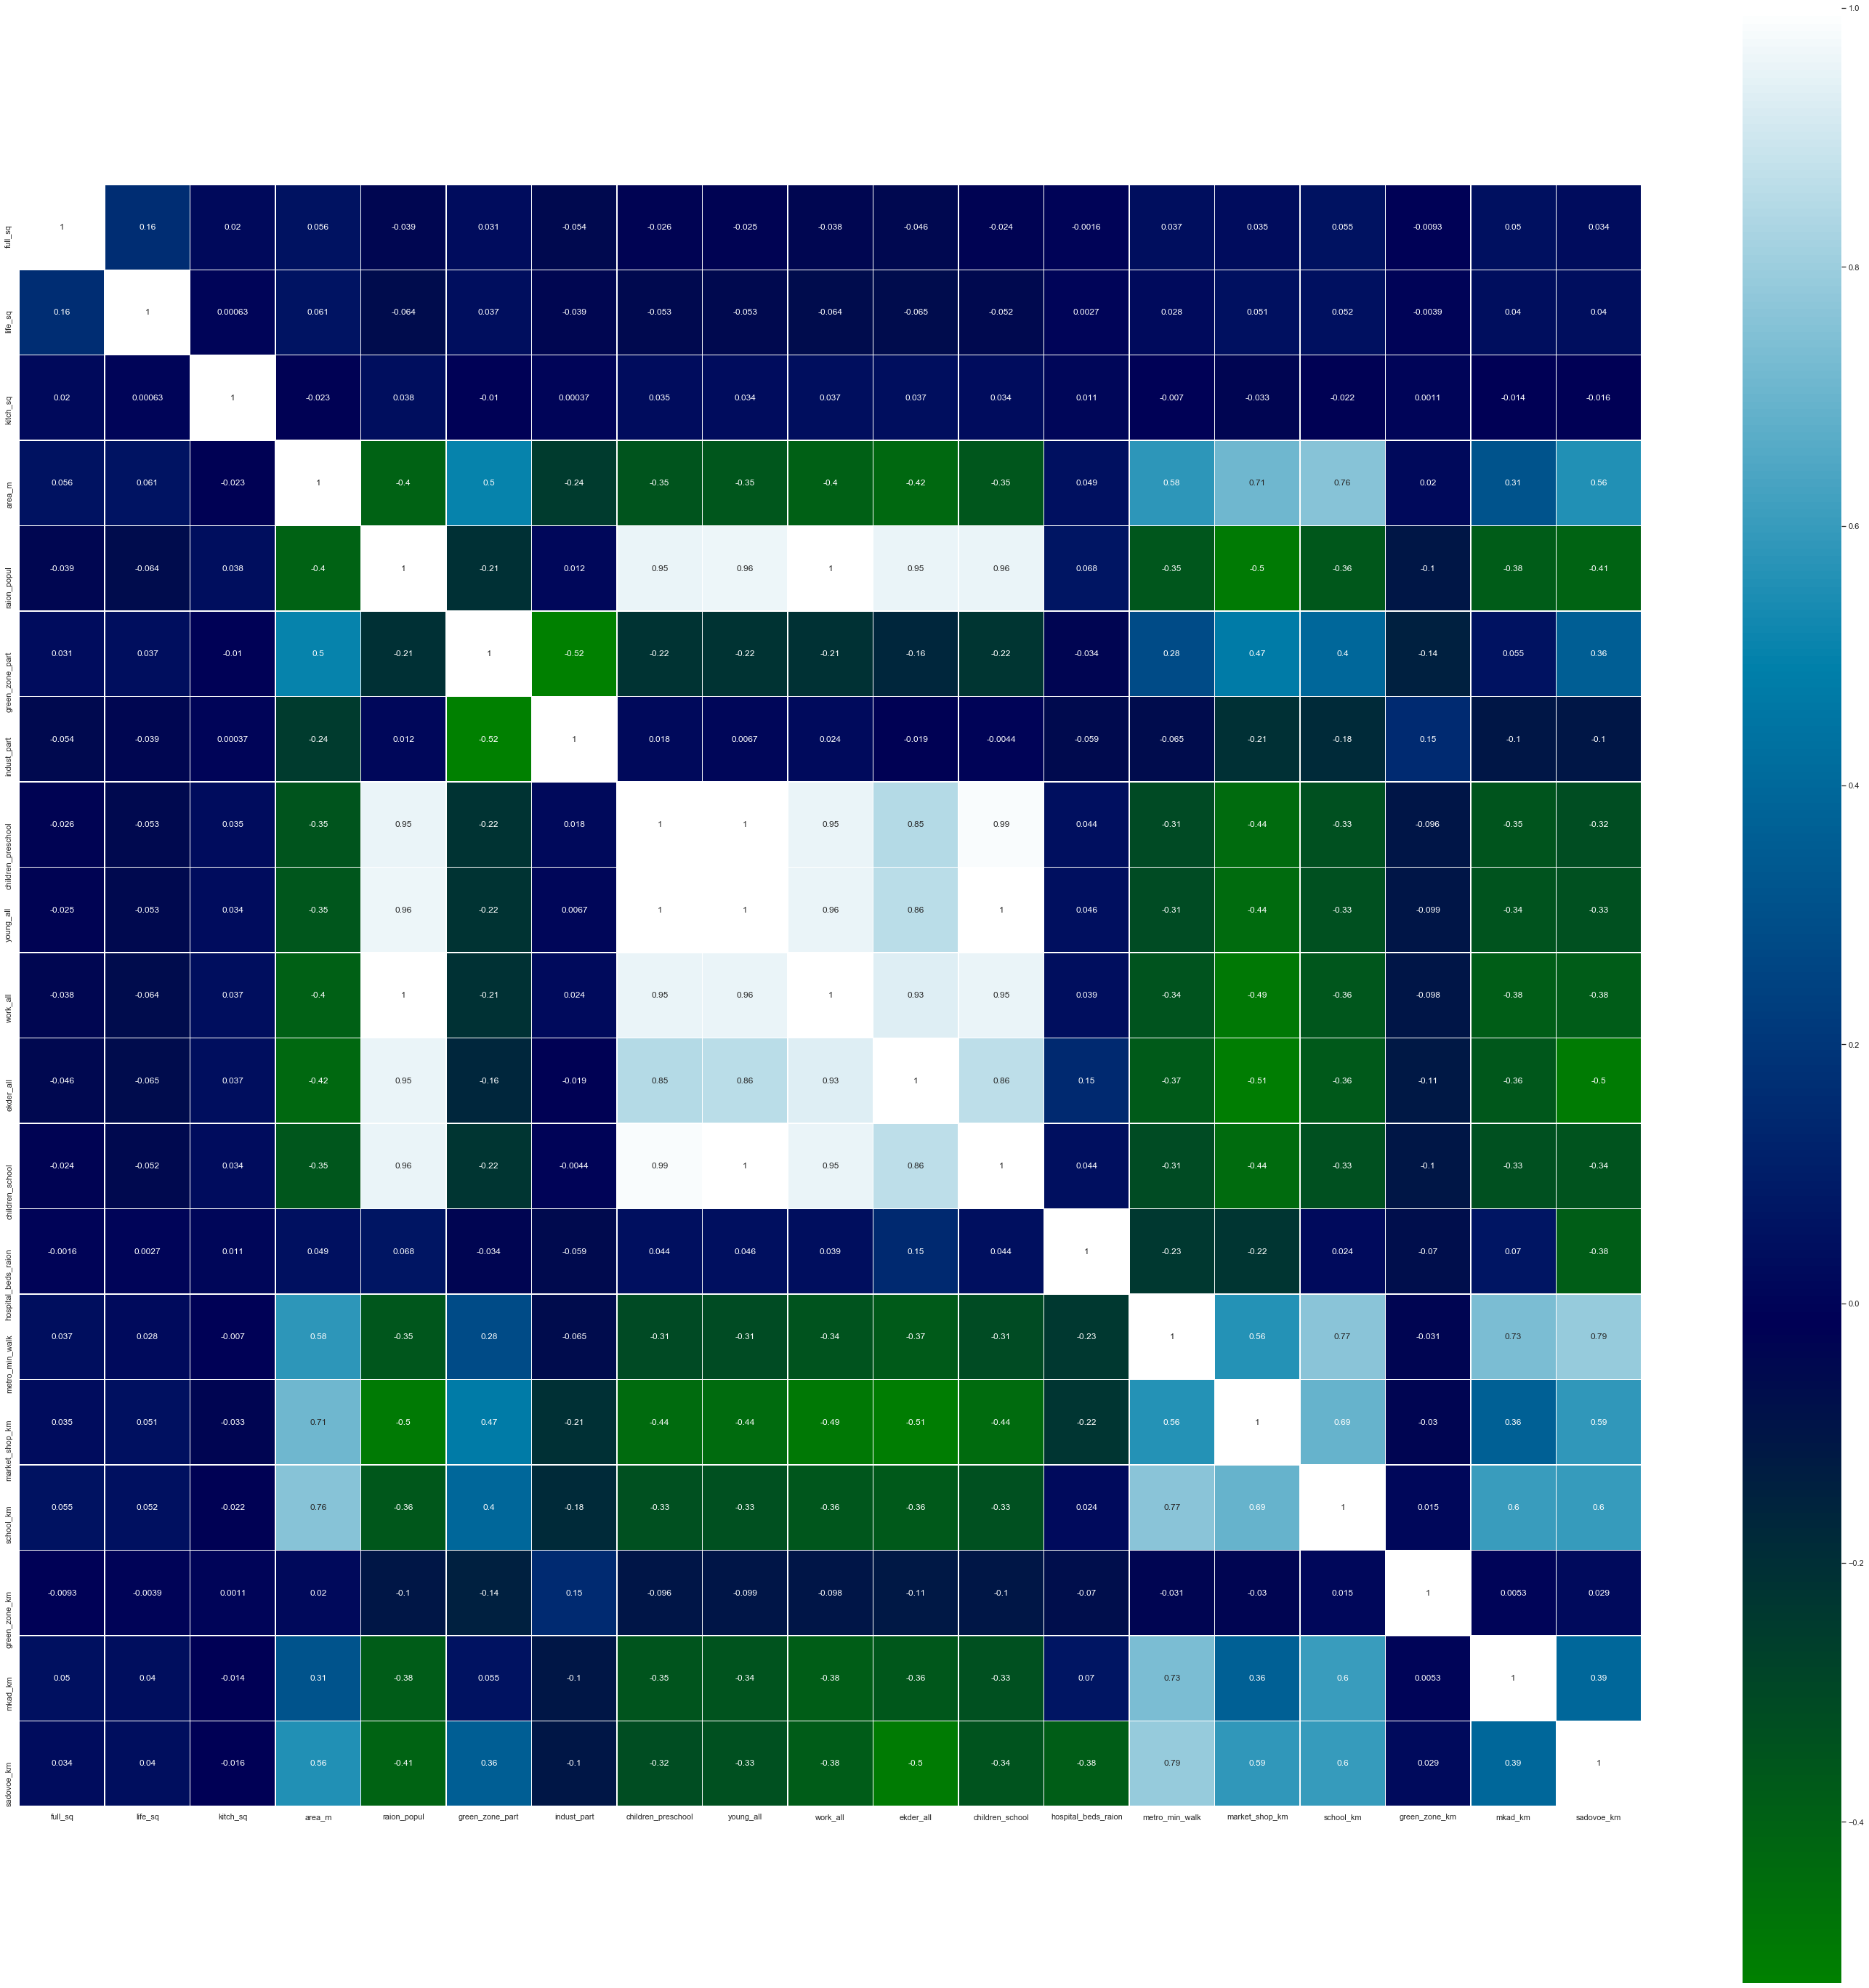

In [56]:
plt.figure(figsize = (50, 50))
sns.heatmap(train_main[float_features].corr(), square = True, cmap = 'ocean', annot = True, linewidth = 0.5)
plt.show()

### Как можно видеть между собой признаки зависят довольно слабо, кроме признаков raion_popul, children_preschool, young_all, work_all, ekder_all, children_school. Ну действительно, эти столбцы все отвечают за численность тех или иных групп людей на районе, естественно они все взаимосвязаны друг с другом, поэтому между ними имеется линейная зависимость, это не есть хорошо. Все остальные столбцы как и ожидалось почти не зависят друг от друга.

## dependence between feature and aim 

### square

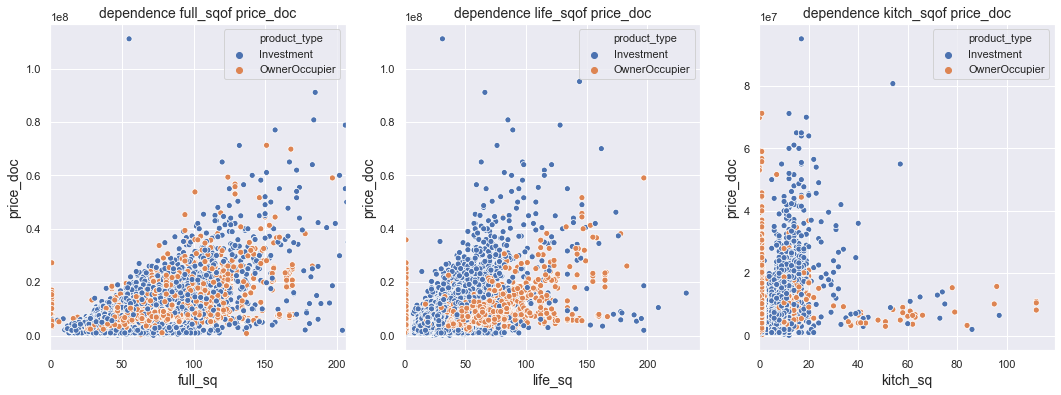

In [57]:
plt.figure(figsize = (18, 6))
square_features = ['full_sq', 'life_sq', 'kitch_sq']
subplot = 0
for feature in square_features:
    subplot += 1
    plt.subplot(1, 3, subplot)
    sns.scatterplot(x = feature, y = 'price_doc', data = train_main, hue = 'product_type')
    plt.xlim(0, np.mean(train_main[feature]) + 4 * np.std(train_main[feature]))
    plt.title('dependence ' + feature + 'of price_doc', fontsize = 14)
    plt.xlabel(feature ,fontsize = 14)
    plt.ylabel('price_doc',fontsize = 14)
    plt.legend()
plt.show()

### *Как можно видеть зависит от цены вся площадь и площадь жилых комнат. Площадь кухни почти не влияет на цену недвижимости.*

### place_km

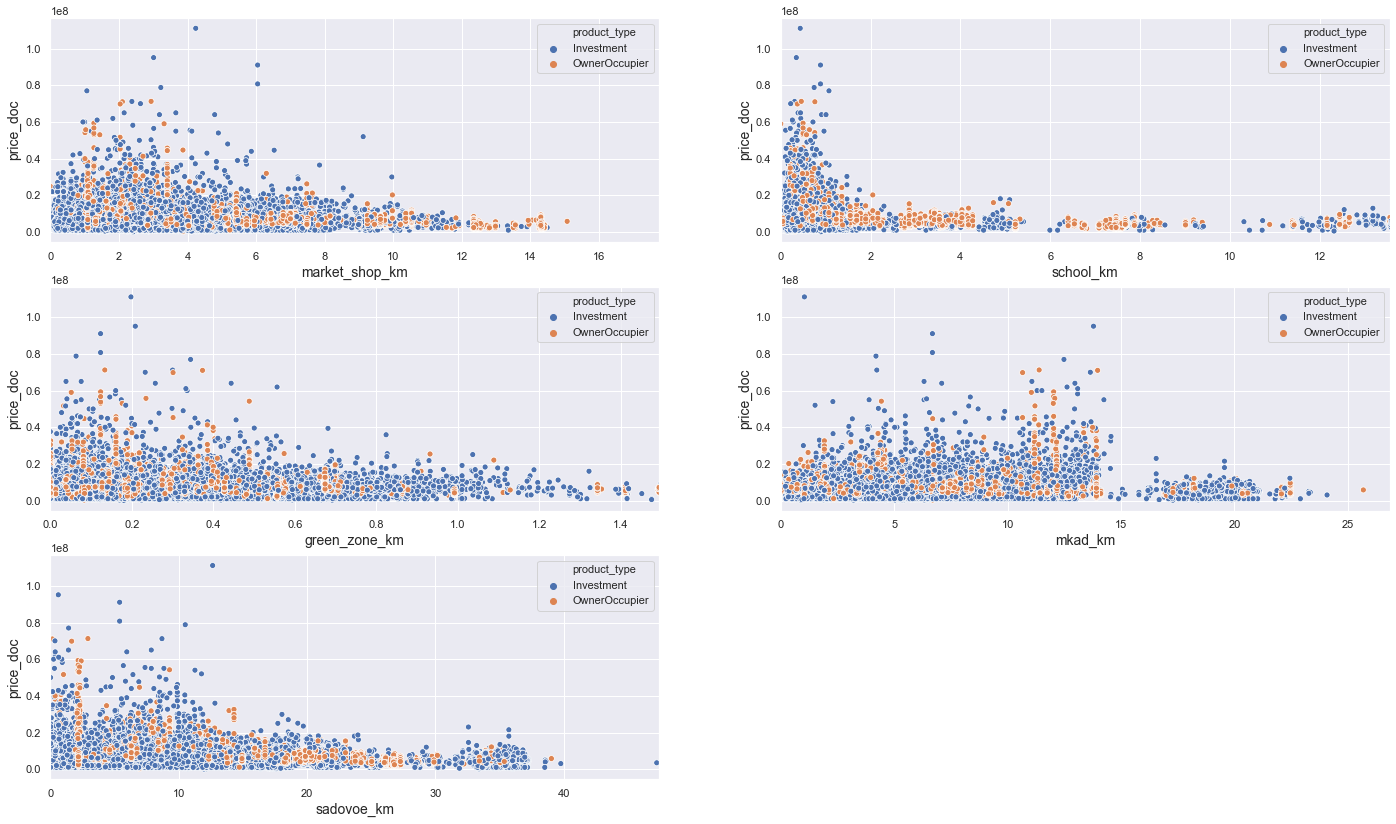

In [58]:
plt.figure(figsize = (24, 14))
km_features = ['market_shop_km', 'school_km', 'green_zone_km', 'mkad_km', 'sadovoe_km']
subplot = 0
for feature in km_features:
    subplot += 1
    plt.subplot(3, 2, subplot)
    sns.scatterplot(x = feature, y = 'price_doc', data = train_main, hue = 'product_type')
    plt.xlim(0, np.mean(train_main[feature]) + 4 * np.std(train_main[feature]))
    plt.xlabel(feature, fontsize = 14)
    plt.ylabel('price_doc', fontsize = 14)
plt.show()

### *Можно заметить, что при увеличении расстояния от магазина, школы, зелёных зон, Садового цена увеличивается. При увеличении же расстояния от МКАДа цена ведет себя не однозначно, поскольку от "центра" МКАДа располагается 2 зоны - даль центра и близость к центру Москвы, поэтому параметр очень неоднозначный.*

### population

In [59]:
population_features = ['raion_popul', 'children_preschool', 'children_school', 'young_all', 'work_all', 'ekder_all']

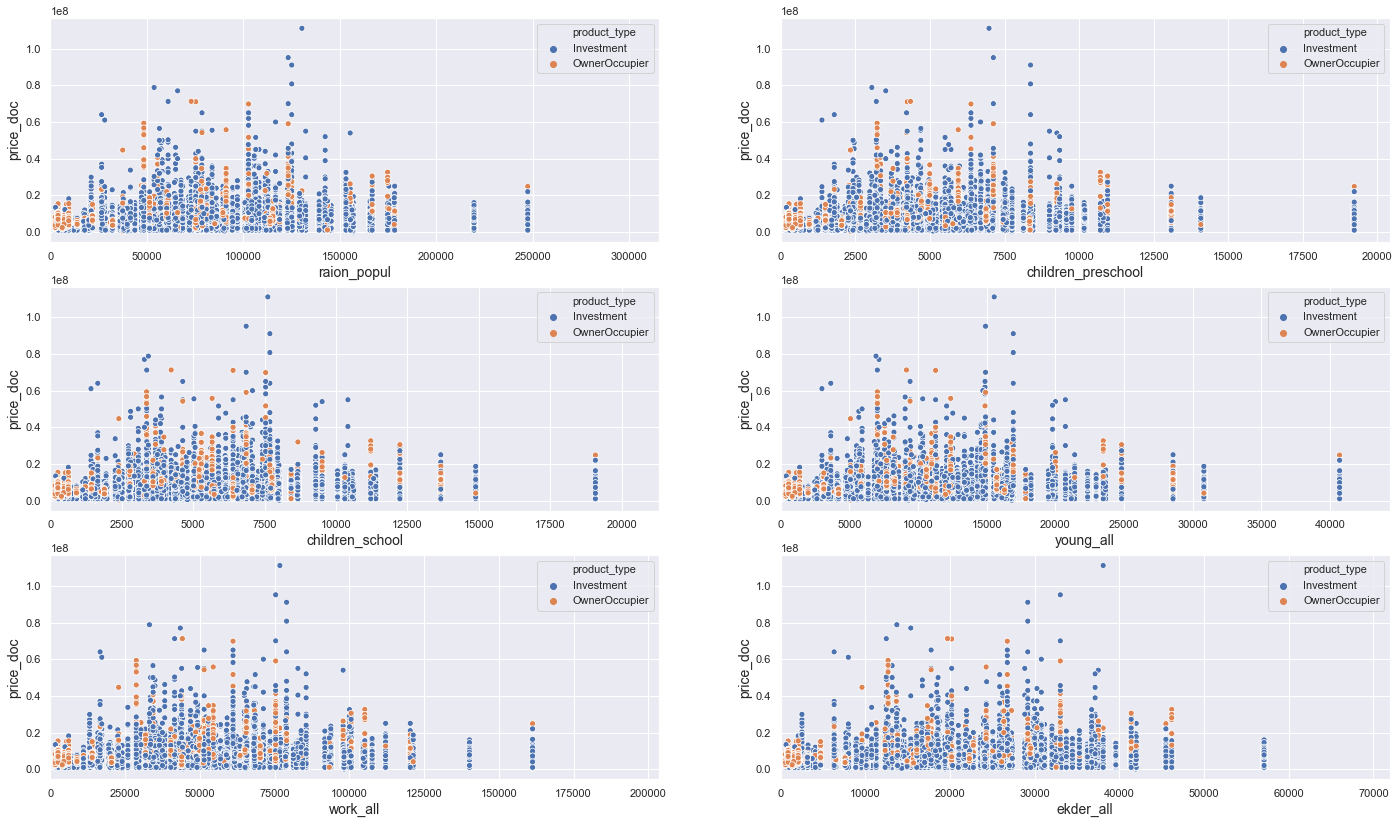

In [60]:
plt.figure(figsize = (24, 14))
km_features = ['market_shop_km', 'school_km', 'green_zone_km', 'mkad_km', 'sadovoe_km']
subplot = 0
for feature in population_features:
    subplot += 1
    plt.subplot(3, 2, subplot)
    sns.scatterplot(x = feature, y = 'price_doc', data = train_main, hue = 'product_type')
    plt.xlim(0, np.mean(train_main[feature]) + 4 * np.std(train_main[feature]))
    plt.xlabel(feature, fontsize = 14)
    plt.ylabel('price_doc', fontsize = 14)
plt.show()

### *Все графики приблизительно одинаковы, что подчеркивала и их корреляция друг между другом, однако зависимости между этими переменными и ценой на недвижимости практически нету.*

## floor

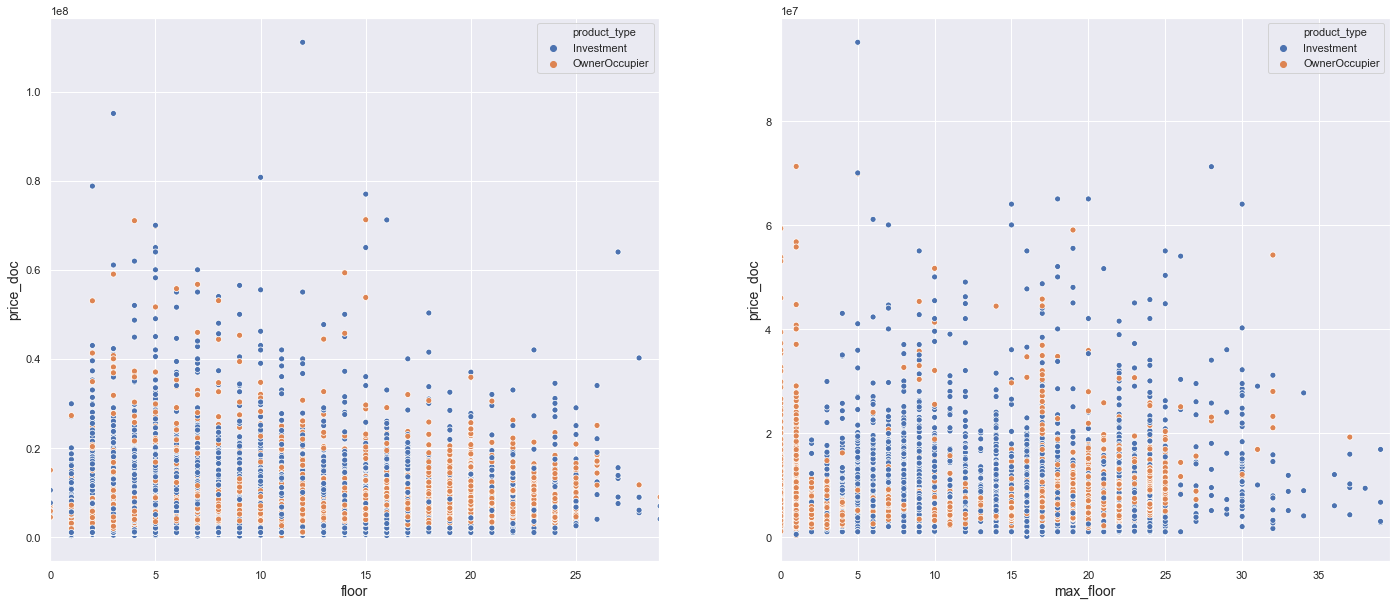

In [61]:
plt.figure(figsize = (24, 10))
floor_features = ['floor', 'max_floor']
subplot = 0
for feature in floor_features:
    subplot += 1
    plt.subplot(1, 2, subplot)
    sns.scatterplot(x = feature, y = 'price_doc', data = train_main, hue = 'product_type')
    plt.xlim(0, np.mean(train_main[feature]) + 4 * np.std(train_main[feature]))
    plt.xlabel(feature, fontsize = 14)
    plt.ylabel('price_doc', fontsize = 14)
plt.show()

## num_room, green_zone_part, indust_part, area_m, hospital_beds

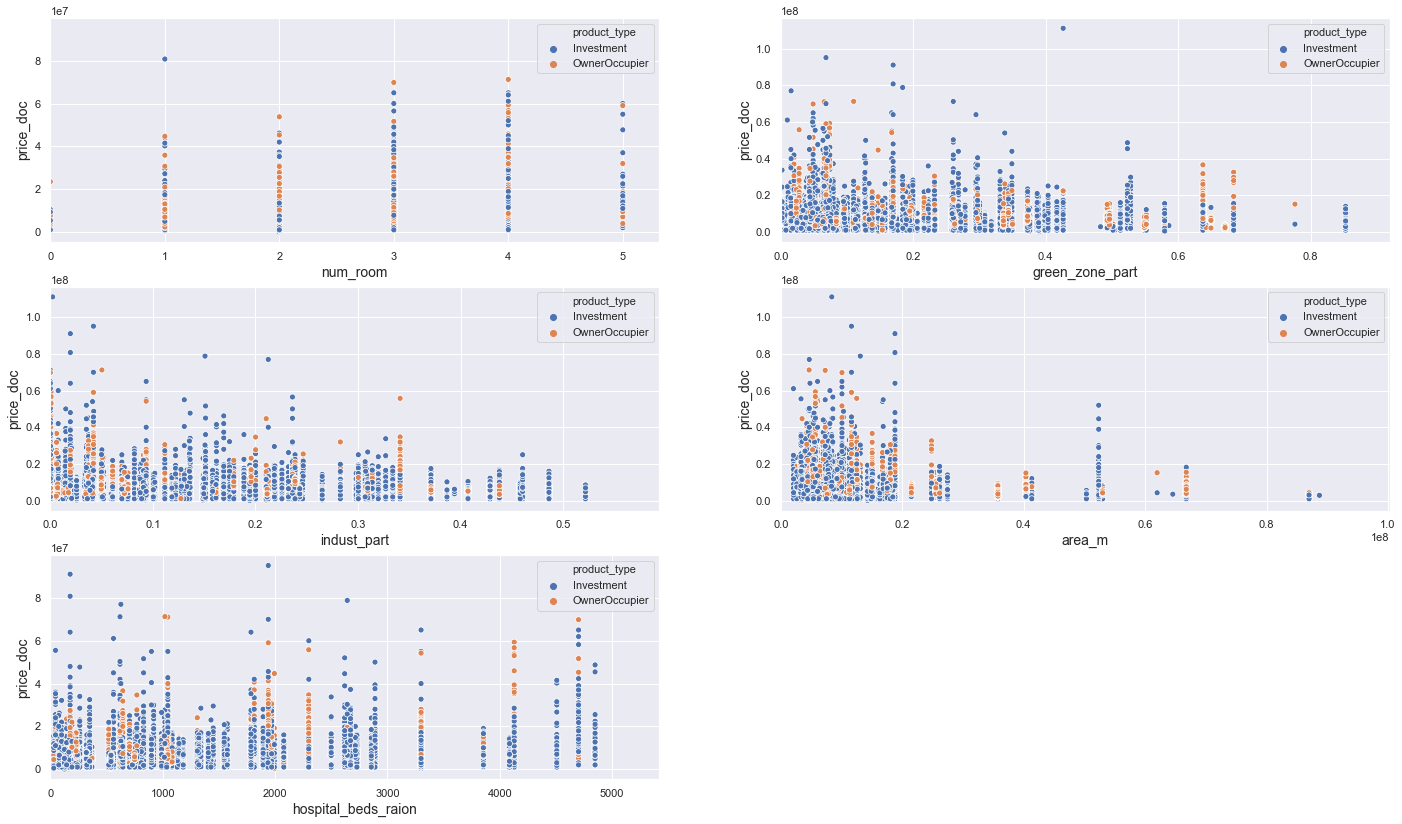

In [62]:
other_features = ['num_room', 'green_zone_part', 'indust_part', 'area_m', 'hospital_beds_raion']
plt.figure(figsize = (24, 14))
subplot = 0
for feature in other_features:
    subplot += 1
    plt.subplot(3, 2, subplot)
    sns.scatterplot(x = feature, y = 'price_doc', data = train_main, hue = 'product_type')
    plt.xlim(0, np.mean(train_main[feature]) + 4 * np.std(train_main[feature]))
    plt.xlabel(feature, fontsize = 14)
    plt.ylabel('price_doc', fontsize = 14)
plt.show()

In [63]:
train_main.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,young_all,work_all,ekder_all,price_doc,children_school,hospital_beds_raion,metro_min_walk,market_shop_km,school_km,green_zone_km,mkad_km,sadovoe_km,year,month,week_of_year,week_count
0,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,9576,21154,98207,36211,5850000,10309,240.0,13.575119,1.676258,0.177975,0.600973,1.422391,13.100618,2011,8,33,33
1,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,6880,15727,70194,29431,6000000,7759,229.0,7.620630,3.424716,0.273345,0.065321,9.503405,6.444333,2011,8,34,34
2,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,5879,13028,63388,25292,5700000,6207,1183.0,17.351515,1.375443,0.158072,0.453172,5.604800,6.963403,2011,8,34,34
3,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,13087,28563,120381,29529,13100000,13670,NaN,11.565624,0.811275,0.236455,0.106125,2.677824,17.457198,2011,9,35,35
4,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,5706,13368,68043,26760,16331452,6748,562.0,8.266305,1.969738,0.376838,0.236214,11.616653,0.046810,2011,9,36,36


### *От количества комнат в среднем недвижимость растет. От столбца 'area_m' в целом немного зависит. Цена на недвижимость немного зависит от 'indust_part' и 'green_zone_part'.*

### *Зависимости между стоимостью недвижимостью и этажами практически нету.*

## *В итоге выкидываем столбцы 'children_preschool', 'children_school', 'young_all', 'work_all', 'ekder_all', 'mkad_km', 'kitch_sq', 'floor', 'max_floor'. Выкинем эти столбцы из таблицы.* 

In [64]:
train_main = train_main.drop(['children_preschool', 'young_all', 'work_all', 'ekder_all', 'children_school',
                              'floor', 'max_floor', 'kitch_sq', 'mkad_km'], axis = 1)

# Building prediction model on that data

In [65]:
train_data = train_main.drop(['timestamp', 'year', 'month', 'week_of_year', 'material'], axis = 1)

## categorical features

In [66]:
train_data = pd.get_dummies(train_data, drop_first = True)

In [67]:
X = train_data.drop(['price_doc'], axis = 1)
Y = train_data['price_doc']

## filling Nan's

In [68]:
def nan(feature):
    if (X[feature].dtype == 'float'):
        median = X[X[feature].isnull() == False][feature].median()
        X[feature] = X[feature].fillna(median)
    else:
        median = int(X[train_data[feature].isnull() == False][feature].median())
        X[feature] = X[feature].fillna(median)

In [69]:
nan('life_sq')
nan('build_year')
nan('num_room')
nan('hospital_beds_raion')
nan('metro_min_walk')

In [70]:
X.isnull().sum()

full_sq                       0
life_sq                       0
build_year                    0
num_room                      0
area_m                        0
                             ..
sub_area_Vyhino-Zhulebino     0
sub_area_Zamoskvorech'e       0
sub_area_Zapadnoe Degunino    0
sub_area_Zjablikovo           0
sub_area_Zjuzino              0
Length: 161, dtype: int64

## split data

In [71]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size = 0.2, random_state = 1)

## scaler data

In [72]:
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

## GradientBoostingRegressor model

In [73]:
gradient = ensemble.GradientBoostingRegressor()

## learning model

In [74]:
gradient.fit(X_train_scaled, y_train)
predictions = gradient.predict(X_test_scaled)

## metrics

### mean_absolute_error

In [75]:
metrics.mean_absolute_error(predictions, y_test)

2102714.9825031194

### mean_squared_error

In [76]:
metrics.mean_squared_error(predictions, y_test)

12816822924302.725

### *Как можно видеть в среднем модель ошибается на 1500000 рублей. Результат не очень хорош, давайте 1) присоединим ещё параметры к обучению модели 2) поработаем с признаками объектов 3) поработаем с параметрами модели. Посмотрим на результат ошибки модели после этого.*

# Upgrading Model

# all features analysis

## adding new features columns

In [77]:
train['timestamp'] = pd.to_datetime(train['timestamp'], format = '%Y-%m-%d')
train['year'] = train['timestamp'].dt.year
train['month'] = train['timestamp'].dt.month
train['week_of_year'] = train['timestamp'].dt.weekofyear

In [78]:
def week_number(row):
    year = row['year']
    week_number = row['week_of_year']
    if (year == 2011):
        return week_number
    if (year == 2012):
        return week_number + 52
    if (year == 2013):
        return week_number + 2 * 52
    if (year == 2014):
        return week_number + 3 * 52
    if (year == 2015):
        return week_number + 4 * 52
train['week_count'] = train.apply(week_number, axis = 1)

In [79]:
def floor_type(row):
    if (row['floor'] <= 4):
        return 'small_floor'
    if ((row['floor'] > 4) & (row['floor'] <= 12)):
        return 'middle_floor'
    else:
        return 'high_floor'
train['floor_type'] = train.apply(floor_type, axis = 1)

## removing extra columns

In [80]:
train = train.drop(['id', 'timestamp', 'month', 'week_of_year', 'ID_railroad_station_walk', 'ID_metro',
                    'ID_railroad_station_avto'], axis = 1)

In [81]:
train = pd.get_dummies(train, drop_first = True)

## filling NaN's

In [82]:
for feature in train.columns:
    if (train[feature].isnull().sum() >= 10000):
        train = train.drop([feature], axis = 1)

In [83]:
features_with_nan = []
for feature in train.columns:
    if (train[feature].isnull().sum() > 0):
        features_with_nan.append(feature)

In [84]:
features_with_nan

['life_sq',
 'floor',
 'max_floor',
 'material',
 'num_room',
 'kitch_sq',
 'preschool_quota',
 'school_quota',
 'raion_build_count_with_material_info',
 'build_count_block',
 'build_count_wood',
 'build_count_frame',
 'build_count_brick',
 'build_count_monolith',
 'build_count_panel',
 'build_count_foam',
 'build_count_slag',
 'build_count_mix',
 'raion_build_count_with_builddate_info',
 'build_count_before_1920',
 'build_count_1921-1945',
 'build_count_1946-1970',
 'build_count_1971-1995',
 'build_count_after_1995',
 'metro_min_walk',
 'metro_km_walk',
 'railroad_station_walk_km',
 'railroad_station_walk_min',
 'cafe_sum_1000_min_price_avg',
 'cafe_sum_1000_max_price_avg',
 'cafe_avg_price_1000',
 'cafe_sum_1500_min_price_avg',
 'cafe_sum_1500_max_price_avg',
 'cafe_avg_price_1500',
 'cafe_sum_2000_min_price_avg',
 'cafe_sum_2000_max_price_avg',
 'cafe_avg_price_2000',
 'cafe_sum_3000_min_price_avg',
 'cafe_sum_3000_max_price_avg',
 'cafe_avg_price_3000',
 'prom_part_5000',
 'cafe_su

In [85]:
train = train.drop(['floor', 'max_floor', 'material', 'raion_build_count_with_material_info',
                   'raion_build_count_with_builddate_info', 'metro_km_walk', 'railroad_station_walk_min',], axis = 1)

In [86]:
features_with_nan = []
for feature in train.columns:
    if (train[feature].isnull().sum() > 0):
        features_with_nan.append(feature)

In [87]:
features_with_nan

['life_sq',
 'num_room',
 'kitch_sq',
 'preschool_quota',
 'school_quota',
 'build_count_block',
 'build_count_wood',
 'build_count_frame',
 'build_count_brick',
 'build_count_monolith',
 'build_count_panel',
 'build_count_foam',
 'build_count_slag',
 'build_count_mix',
 'build_count_before_1920',
 'build_count_1921-1945',
 'build_count_1946-1970',
 'build_count_1971-1995',
 'build_count_after_1995',
 'metro_min_walk',
 'railroad_station_walk_km',
 'cafe_sum_1000_min_price_avg',
 'cafe_sum_1000_max_price_avg',
 'cafe_avg_price_1000',
 'cafe_sum_1500_min_price_avg',
 'cafe_sum_1500_max_price_avg',
 'cafe_avg_price_1500',
 'cafe_sum_2000_min_price_avg',
 'cafe_sum_2000_max_price_avg',
 'cafe_avg_price_2000',
 'cafe_sum_3000_min_price_avg',
 'cafe_sum_3000_max_price_avg',
 'cafe_avg_price_3000',
 'prom_part_5000',
 'cafe_sum_5000_min_price_avg',
 'cafe_sum_5000_max_price_avg',
 'cafe_avg_price_5000']

In [88]:
input_zero = ['build_count_block', 'build_count_wood', 'build_count_frame', 'build_count_brick', 'build_count_monolith',
              'build_count_panel', 'build_count_foam', 'build_count_slag', 'build_count_mix', 'build_count_before_1920',
              'build_count_1921-1945', 'build_count_1946-1970', 'build_count_1971-1995', 'build_count_after_1995',]
input_median = ['life_sq', 'kitch_sq', 'railroad_station_walk_km', 'cafe_sum_1000_min_price_avg', 'cafe_sum_1000_max_price_avg',
                'cafe_avg_price_1000', 'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg', 'cafe_avg_price_1500',
                'cafe_sum_2000_min_price_avg', 'cafe_sum_2000_max_price_avg', 'cafe_avg_price_2000', 
                'cafe_sum_3000_min_price_avg', 'cafe_sum_3000_max_price_avg', 'cafe_avg_price_3000', 'prom_part_5000',
                'cafe_sum_5000_min_price_avg', 'cafe_sum_5000_max_price_avg', 'cafe_avg_price_5000', 'preschool_quota',
                'school_quota']
input_mines_one = ['num_room', 'metro_min_walk']

In [89]:
for feature in input_zero:
    train[feature] = train[feature].fillna(0)
for feature in input_median:
    if (train[feature].dtype == 'float'):
        median = train[train[feature].isnull() == False][feature].median()
        train[feature] = train[feature].fillna(median)
    else:
        median = int(train[train_data[feature].isnull() == False][feature].median())
        train[feature] = train[feature].fillna(median)
for feature in input_mines_one:
    train[feature] = train[feature].fillna(-1)

In [90]:
train.head()

,full_sq,life_sq,num_room,kitch_sq,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,metro_min_avto,metro_km_avto,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road2_km,ID_big_road2,railroad_km,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_4000,cafe_count_2000_price_high,big_church_count_2000,church_count_2000,mosque_count_2000,leisure_count_2000,sport_count_2000,market_count_2000,green_part_3000,prom_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe

In [91]:
X = train.drop(['price_doc'], axis = 1)
Y = train['price_doc']

## Feature Selection

In [92]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size = 0.2, random_state = 1)

In [93]:
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [94]:
gradient_feature = ensemble.GradientBoostingRegressor()

In [95]:
gradient_feature.fit(X_train, y_train)
predictions = gradient_feature.predict(X_test)

In [96]:
importances = pd.DataFrame(zip(X_train.columns, gradient.feature_importances_))
importances.columns = ['feature_name', 'importance']
importances.sort_values(by='importance', ascending=False).head(50)

,feature_name,importance
0,full_sq,0.595340
13,school_education_centers_raion,0.222141
5,raion_popul,0.022182
9,preschool_quota,0.021828
14,school_education_centers_top_20_raion,0.018335
11,children_school,0.016845
8,children_preschool,0.015776
7,indust_part,0.015064
3,kitch_sq,0.012273
12,school_quota,0.010047


### *Как можно видеть многие признаки довольно бесполезные, было бы неплохо их как-то совокупить так, чтобы вышел 1 полезный признак и помог улучшить модель.*

## let's more working on features

In [97]:
train['main_places_km_average'] = (train['catering_km'] + train['big_market_km'] + train['bus_terminal_avto_km'] + 
                                   train['railroad_station_walk_km'] + train['cemetery_km'] +  train['kindergarten_km'] + 
                                   train['metro_km_avto']) / 7
train = train.drop(['catering_km', 'big_market_km', 'bus_terminal_avto_km', 'railroad_station_walk_km', 'cemetery_km',
                    'kindergarten_km', 'metro_km_avto'], axis = 1)

train['other_places_km_average'] = (train['additional_education_km'] + train['museum_km'] + train['sport_objects_raion'] + 
                                    train['theater_km'] + train['exhibition_km'] + train['mosque_km'] + 
                                    train['church_synagogue_km'] + train['additional_education_raion'] + 
                                    train['big_church_km']) / 9
train = train.drop(['additional_education_km', 'museum_km', 'sport_objects_raion', 'theater_km', 'exhibition_km', 'mosque_km',
                    'church_synagogue_km', 'additional_education_raion', 'big_church_km'], axis = 1)

In [98]:
count = 0
for feature in train.columns:
    if (('km' in feature) and (feature != 'main_places_km_average') and (feature != 'other_places_km_average')):
        train = train.drop([feature], axis = 1)
        
feature_500 = []
for feature in train.columns:
    if (('count_500' in feature) and ('price' not in feature)):
        count += 1
        feature_500.append(feature)
train['features_500'] = 0
for feature in feature_500:
    if (('count_500' in feature) and ('price' not in feature)):
        train['features_500'] += train[feature]
train['features_500'] = train['features_500'] / count

count = 0

feature_1000 = []
for feature in train.columns:
    if (('count_1000' in feature) and ('price' not in feature)):
        count += 1
        feature_1000.append(feature)
train['feature_1000'] = 0
for feature in feature_1000:
    if (('count_1000' in feature) and ('price' not in feature)):
        train['feature_1000'] += train[feature]
train['feature_1000'] = train['feature_1000'] / count

count = 0

feature_1500 = []
for feature in train.columns:
    if (('count_1500' in feature) and ('price' not in feature)):
        count += 1
        feature_1500.append(feature)
train['feature_1500'] = 0
for feature in feature_1500:
    if (('count_1500' in feature) and ('price' not in feature)):
        train['feature_1500'] += train[feature]
train['feature_1500'] = train['feature_1500'] / count

count = 0

feature_2000 = []
for feature in train.columns:
    if (('count_2000' in feature) and ('price' not in feature)):
        count += 1
        feature_2000.append(feature)
train['feature_2000'] = 0
for feature in feature_2000:
    if (('count_2000' in feature) and ('price' not in feature)):
        train['feature_2000'] += train[feature]
train['feature_2000'] = train['feature_2000'] / count

count = 0

feature_3000 = []
for feature in train.columns:
    if (('count_3000' in feature) and ('price' not in feature)):
        count += 1
        feature_3000.append(feature)
train['feature_3000'] = 0
for feature in feature_3000:
    if (('count_3000' in feature) and ('price' not in feature)):
        train['feature_3000'] += train[feature]
train['feature_3000'] = train['feature_3000'] / count

count = 0

feature_5000 = []
for feature in train.columns:
    if (('count_5000' in feature) and ('price' not in feature)):
        count += 1
        feature_5000.append(feature)
train['feature_5000'] = 0
for feature in feature_5000:
    if (('count_5000' in feature) and ('price' not in feature)):
        train['feature_5000'] += train[feature]
train['feature_5000'] = train['feature_5000'] / count

In [99]:
for feature in train.columns:
    if ('_count_' in feature) and ('build' not in feature):
        train = train.drop([feature], axis = 1)

In [100]:
for feature in train.columns:
    if ('price' in feature) and ('cafe_' in feature):
        train = train.drop([feature], axis = 1)

In [101]:
for feature in train.columns:
    if ('male' in feature) or ('female' in feature) or ('ID' in feature) or ('yes' in feature):
        train = train.drop([feature], axis = 1)

In [102]:
for feature in train.columns:
    if ('green_part' in feature)  and ('1500' not in feature):
        train = train.drop([feature], axis = 1)
    if ('prom_part' in feature)  and ('1500' not in feature):
        train = train.drop([feature], axis = 1)
    if ('office_sqm' in feature) and ('1500' not in feature):
        train = train.drop([feature], axis = 1)
    if ('trc_sqm' in feature) and ('1500' not in feature):
        train = train.drop([feature], axis = 1)

In [103]:
train.head()

,full_sq,life_sq,num_room,kitch_sq,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,healthcare_centers_raion,university_top_20_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,young_all,work_all,ekder_all,0_6_all,7_14_all,0_17_all,16_29_all,0_13_all,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,metro_min_avto,metro_min_walk,railroad_station_avto_min,public_transport_station_min_walk,green_part_1500,prom_part_1500,office_sqm_1500,trc_sqm_1500,price_doc,year,week_count,product_type_OwnerOccupier,sub_area_Akademicheskoe,sub_area_Alekseevskoe,sub_area_Altuf'evskoe,sub_area_Arbat,sub_area_Babushkinskoe,sub_area_Basmannoe,sub_area_Begovoe,sub_area_Beskudnikovskoe,sub_area_Bibirevo,sub_area_Birjulevo Vostochnoe,sub_area_Birjulevo Zapadnoe,sub_area_Bogorodskoe,sub_area_Brateevo,sub_area_Butyrskoe,sub_area_Caricyno,sub_area_Cheremushki,sub_area_Chertanovo Central'noe,sub_area_Chertanovo Juzhnoe,sub_area_Chertanovo Severnoe,sub_area_Danilovskoe,sub_area_Dmitrovskoe,sub_area_Donskoe,sub_area_Dorogomilovo,sub_area_Filevskij Park,sub_area_Fili Davydkovo,sub_area_Gagarinskoe,sub_area_Gol'janovo,sub_area_Golovinskoe,sub_area_Hamovniki,sub_area_Horoshevo-Mnevniki,sub_area_Horoshevskoe,sub_area_Hovrino,sub_area_Ivanovskoe,sub_area_Izmajlovo,sub_area_Jakimanka,sub_area_Jaroslavskoe,sub_area_Jasenevo,sub_area_Juzhnoe Butovo,sub_area_Juzhnoe Medvedkovo,sub_area_Juzhnoe Tushino,sub_area_Juzhnoportovoe,sub_area_Kapotnja,sub_area_Kon'kovo,sub_area_Koptevo,sub_area_Kosino-Uhtomskoe,sub_area_Kotlovka,sub_area_Krasnosel'skoe,sub_area_Krjukovo,sub_area_Krylatskoe,sub_area_Kuncevo,sub_area_Kurkino,sub_area_Kuz'minki,sub_area_Lefortovo,sub_area_Levoberezhnoe,sub_area_Lianozovo,sub_area_Ljublino,sub_area_Lomonosovskoe,sub_area_Losinoostrovskoe,sub_area_Mar'ina Roshha,sub_area_Mar'ino,sub_area_Marfino,sub_area_Matushkino,sub_area_Meshhanskoe,sub_area_Metrogorodok,sub_area_Mitino,sub_area_Molzhaninovskoe,sub_area_Moskvorech'e-Saburovo,sub_area_Mozhajskoe,sub_area_Nagatino-Sadovniki,sub_area_Nagatinskij Zaton,sub_area_Nagornoe,sub_area_Nekrasovka,sub_area_Nizhegorodskoe,sub_area_Novo-Peredelkino,sub_area_Novogireevo,sub_area_Novokosino,sub_area_Obruchevskoe,sub_area_Ochakovo-Matveevskoe,sub_area_Orehovo-Borisovo Juzhnoe,sub_area_Orehovo-Borisovo Severnoe,sub_area_Ostankinskoe,sub_area_Otradnoe,sub_area_Pechatniki,sub_area_Perovo,sub_area_Pokrovskoe Streshnevo,sub_area_Poselenie Desjonovskoe,sub_area_Poselenie Filimonkovskoe,sub_area_Poselenie Kievskij,sub_area_Poselenie Klenovskoe,sub_area_Poselenie Kokoshkino,sub_area_Poselenie Krasnopahorskoe,sub_area_Poselenie Marushkinskoe,sub_area_Poselenie Mihajlovo-Jarcevskoe,sub_area_Poselenie Moskovskij,sub_area_Poselenie Mosrentgen,sub_area_Poselenie Novofedorovskoe,sub_area_Poselenie Pervomajskoe,sub_area_Poselenie Rjazanovskoe,sub_area_Poselenie Rogovskoe,sub_area_Poselenie Shhapovskoe,sub_area_Poselenie Shherbinka,sub_area_Poselenie Sosenskoe,sub_area_Poselenie Vnukovskoe,sub_area_Poselenie Voronovskoe,sub_area_Poselenie Voskresenskoe,sub_area_Preobrazhenskoe,sub_area_Presnenskoe,sub_area_Prospekt Vernadskogo,sub_area_Ramenki,sub_area_Rjazanskij,sub_area_Rostokino,sub_area_Savelki,sub_area_Savelovskoe,sub_area_Severnoe,sub_area_Severnoe Butovo,sub_area_Severnoe Izmajlovo,sub_area_Severnoe Medvedkovo,sub_area_Severnoe Tushino,sub_area_Shhukino,sub_area_Silino,sub_area_Sokol,sub_area_Sokol'niki,sub_area_Sokolinaja Gora,sub_area_Solncevo,sub_area_Staroe Krjukovo,sub_area_Strogino,sub_area_Sviblovo,sub_area_Taganskoe,sub_area_Tekstil'shhiki,sub_area_Teplyj Stan,sub_area_Timirjazevskoe,sub_area_Troickij

### *Попробуем с такой преобразованной таблицей построить обучающую модель.*

# Final models creating

In [104]:
X = train.drop(['price_doc'], axis = 1)
Y = train['price_doc']

## scaling data

In [105]:
# scaler = preprocessing.MinMaxScaler()
# X_scaled = scaler.fit_transform(X)

## train, test split

In [106]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size = 0.2, random_state = 1251)

## regr fitting and predicting

In [107]:
regr1 = ensemble.GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.01, random_state = 1251)

In [108]:
regr1.fit(X_train, y_train)
predictions1 = regr1.predict(X_test)

##  metrics

In [109]:
metrics.mean_absolute_error(predictions1, y_test)

2058421.771505785

In [110]:
importances = pd.DataFrame(zip(X.columns, regr1.feature_importances_))
importances.columns = ['feature_name', 'importance']
importances.sort_values(by='importance', ascending=False).head(10)

,feature_name,importance
0,full_sq,0.659828
210,feature_2000,0.113498
211,feature_3000,0.075493
208,feature_1000,0.042500
212,feature_5000,0.041305
207,features_500,0.031004
2,num_room,0.013591
33,build_count_monolith,0.008538
209,feature_1500,0.003200
205,main_places_km_average,0.003095


### *Как можно видеть, модель отработала достаточно плохо, несмотря на преобразование признаков. Они конечно вошли в топ важных признаков, но у первого по важности - площадь недвижимости всё ещё осталось 66% важности, а это очень много и сбивает точность. Поэтому в этой модели градиентный спуск - не самый лучший алгоритм.*

### Let's try other model - RandomForestRegressor

In [111]:
regr2 = ensemble.RandomForestRegressor(n_estimators = 100, random_state = 1251)

In [112]:
regr2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1251, verbose=0, warm_start=False)

In [113]:
predictions2 = regr2.predict(X_test)

In [114]:
metrics.mean_absolute_error(predictions2, y_test)

1341790.5336300188

In [115]:
importances = pd.DataFrame(zip(X.columns, regr2.feature_importances_))
importances.columns = ['feature_name', 'importance']
importances.sort_values(by='importance', ascending=False).head(15)

,feature_name,importance
0,full_sq,0.416064
211,feature_3000,0.086485
210,feature_2000,0.070843
52,week_count,0.034508
212,feature_5000,0.025606
47,green_part_1500,0.023661
207,features_500,0.020777
46,public_transport_station_min_walk,0.019811
205,main_places_km_average,0.018569
208,feature_1000,0.018320


### *Случайные леса справились намного лучше и понизили ошибку примерно на треть. На первом месте по важности по-прежнему площадь недвижимости, но её важность теперь около 42% < 50%, что уже достаточно хорошо. Также важно, что на важность от 1% повлияло больше 15 признаков, в том числе и созданные признаки, а значит и модель отработала очень даже неплохо.*

In [123]:
dtrain = xgb.DMatrix(X_train, y_train, feature_names=X.columns)
dtest = xgb.DMatrix(X_test, feature_names=X.columns)

In [124]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

In [126]:
partial_model = xgb.train(xgb_params, dtrain, num_boost_round=1000, verbose_eval=20)

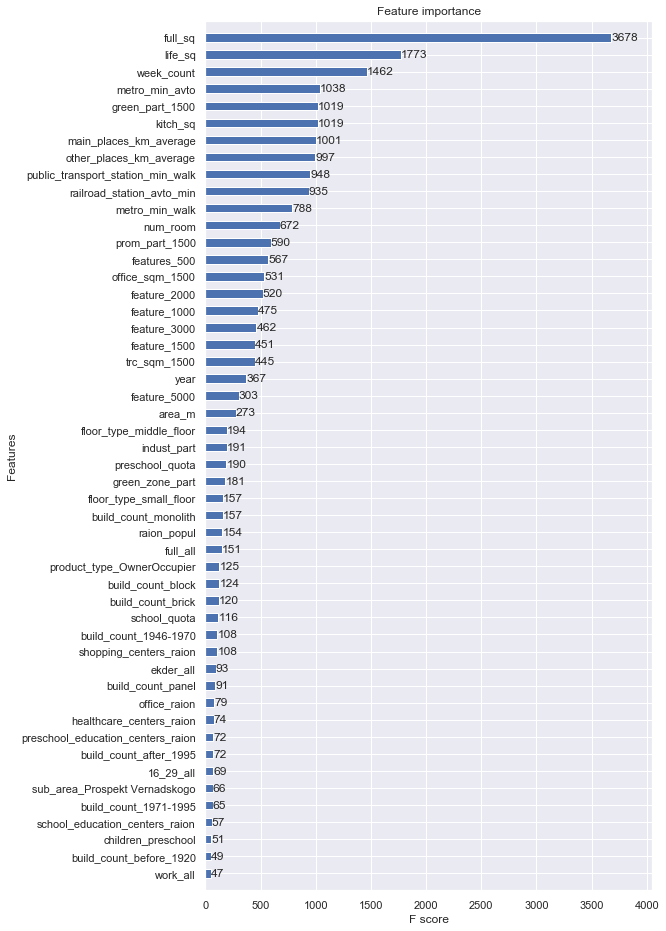

In [128]:
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(partial_model, max_num_features=50, height=0.5, ax=ax)
plt.show()

In [129]:
predictions  = partial_model.predict(dtest)

In [130]:
metrics.mean_absolute_error(predictions, y_test)

1358484.8926989336

### *Как можно видеть xgboost тоже очень неплохо справляется, поэтому и xgboost и RandomForest очень неплохи для этой модели и учитывают по важности достаточно предсказуемые признаки.*

# Итого: Лучшая модель(regr2 - RandomForestClassifier) показала среднюю абсолютную ошибку - 1342000 рублей.